In [1]:
import BenchmarkTools: @btime, @benchmark;

import Pkg: activate, build
activate("../GSHEIntegrator/.")
import GSHEIntegrator;

using Plots
using NPZ

  Activating project at `~/Projects/birefringence/GSHEIntegrator`
┌ Info: Precompiling GSHEIntegrator [95376d2f-314f-47c4-97a6-da6eee6a3a26]
└ @ Base loading.jl:1423


In [47]:
geometry = GSHEIntegrator.setup_geometry(
    rsource=8, θsource=π/2, ϕsource=0,
    robs=50, θobs=0.4π, ϕobs=π,
    a=0.99)

ϵs = (10).^LinRange(-3, -0.5, 100)

geometry.ode_options.no_loops = false
geometry.ode_options.Δθ = 0.000
geometry.ode_options.horizon_tol = 1.001
geometry.ode_options.maxiters = 30000

function spherical_to_shadow(X)
    ψ, ρ = X
    k3 = cos(ψ)
    k2 = sin(ψ) * sin(ρ)
    return [k2, k3]
end

spherical_to_shadow (generic function with 1 method)

In [48]:
Xgeo = GSHEIntegrator.find_geodesic_minima(geometry, 2)

2×4 Matrix{Float64}:
 2.01328  2.38538  69.6616  1.13137
 1.26245  4.01168  64.7217  1.13137

In [49]:
Xgshe = GSHEIntegrator.solve_gshe(Xgeo, geometry, ϵs);

n=1, 1.00%, ϵ=1.00e-03
n=1, 2.00%, ϵ=1.06e-03
n=1, 3.00%, ϵ=1.12e-03
n=1, 4.00%, ϵ=1.19e-03
n=1, 5.00%, ϵ=1.26e-03
n=1, 6.00%, ϵ=1.34e-03
n=1, 7.00%, ϵ=1.42e-03
n=1, 8.00%, ϵ=1.50e-03
n=1, 9.00%, ϵ=1.59e-03
n=1, 10.00%, ϵ=1.69e-03
n=1, 11.00%, ϵ=1.79e-03
n=1, 12.00%, ϵ=1.90e-03
n=1, 13.00%, ϵ=2.01e-03
n=1, 14.00%, ϵ=2.13e-03
n=1, 15.00%, ϵ=2.26e-03
n=1, 16.00%, ϵ=2.39e-03
n=1, 17.00%, ϵ=2.54e-03
n=1, 18.00%, ϵ=2.69e-03
n=1, 19.00%, ϵ=2.85e-03
n=1, 20.00%, ϵ=3.02e-03
n=1, 21.00%, ϵ=3.20e-03
n=1, 22.00%, ϵ=3.39e-03
n=1, 23.00%, ϵ=3.59e-03
n=1, 24.00%, ϵ=3.81e-03
n=1, 25.00%, ϵ=4.04e-03
n=1, 26.00%, ϵ=4.28e-03
n=1, 27.00%, ϵ=4.53e-03
n=1, 28.00%, ϵ=4.81e-03
n=1, 29.00%, ϵ=5.09e-03
n=1, 30.00%, ϵ=5.40e-03
n=1, 31.00%, ϵ=5.72e-03
n=1, 32.00%, ϵ=6.06e-03
n=1, 33.00%, ϵ=6.43e-03
n=1, 34.00%, ϵ=6.81e-03
n=1, 35.00%, ϵ=7.22e-03
n=1, 36.00%, ϵ=7.65e-03
n=1, 37.00%, ϵ=8.11e-03
n=1, 38.00%, ϵ=8.60e-03
n=1, 39.00%, ϵ=9.11e-03
n=1, 40.00%, ϵ=9.66e-03
n=1, 41.00%, ϵ=1.02e-02
n=1, 42.00%, ϵ=1.08e-02
n

In [50]:
geometry.direction_coords = :spherical

:spherical

In [51]:
# Geometric trajectories
Xgeos_cartesian = zeros(2, 3, 250) .* NaN
for i in 1:2
    X = GSHEIntegrator.cartesian_trajectory(Xgeo[i, 1:2], geometry, true)
    n = size(X)[2]
    Xgeos_cartesian[i, :, 1:n] .= X
end
Xgeos_cartesian


# GSHE trajectories
Xgshe_cartesian = zeros(2, 2, 30, 3, 1000) .* NaN
for i in 1:2, s in 1:2, j in 1:30
   X = GSHEIntegrator.cartesian_trajectory(Xgshe[i, s, j, 1:2], geometry, false, ϵs[j], s == 1 ? 2 : -2)
   n = size(X)[2]
   Xgshe_cartesian[i, s, j, :, 1:n] .= X
end



In [5]:
geometry.direction_coords = :shadow
N = 2500
# θs = reverse(acos.(LinRange(-1, 1, N)))
# θs = Vector(LinRange(0, π, N))
# ϕs = Vector(LinRange(0, 2π, N))
k2 = LinRange(-1, 1, N)
k3 = LinRange(-1, 1, N)
loss = GSHEIntegrator.setup_geodesic_loss(geometry);
Z = GSHEIntegrator.grid_evaluate(loss, k2, k3);

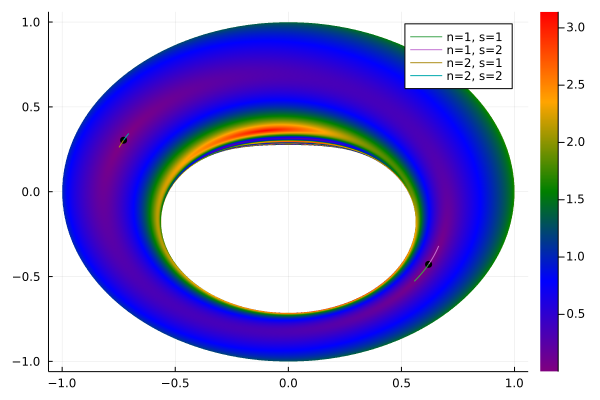

┌ Info: Precompiling GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9]
└ @ Base loading.jl:1423


In [6]:

fig = Plots.heatmap(k2, k3, Z, c=:rainbow, dpi=600)

X = mapslices(spherical_to_shadow, Xgeo[:, 1:2], dims=2)
Plots.scatter!(fig, X[:, 1], X[:, 2], c=:black, label=nothing)

for n in 1:2, s in 1:2
    X = mapslices(spherical_to_shadow, Xgshe[n, s, :, 1:2], dims=2)
    Plots.plot!(fig,  X[:, 1], X[:, 2], label="n=$n, s=$s")
end

# Plots.savefig(fig, "~/Downloads/shadow.png")
display(fig)

In [62]:
runID = "03"
coords = zeros(N, 2)
coords[:, 1] = k2
coords[:, 2] = k3


npzwrite("/Users/richard/Projects/birefringence/data/$(runID)_Epsilons.npy", ϵs)
npzwrite("/Users/richard/Projects/birefringence/data/$(runID)_dataZ.npy", Z)
npzwrite("/Users/richard/Projects/birefringence/data/$(runID)_dataCoords.npy", coords)
npzwrite("/Users/richard/Projects/birefringence/data/$(runID)_Xgeo.npy", Xgeo)
npzwrite("/Users/richard/Projects/birefringence/data/$(runID)_Xgshe.npy", Xgshe)
npzwrite("/Users/richard/Projects/birefringence/data/$(runID)_Xgeo_cartesian.npy", Xgeos_cartesian)
npzwrite("/Users/richard/Projects/birefringence/data/$(runID)_Xgshe_cartesian.npy", Xgshe_cartesian)
open("/Users/richard/Projects/birefringence/data/$(runID)Description.txt", "w") do f
    write(f, "rsource=8, thetasource=0.5pi, phisource=0, robs=50, thetaobs=0.4pi, phiobs=pi, a=0.99")
end

85